# Week 47

v1.0.0

In [1]:
try:
    import fysisk_biokemi
    print("Already installed")
except ImportError:
    %pip install -q "fysisk_biokemi[colab] @ git+https://github.com/au-mbg/fysisk-biokemi.git"

------------------------------------------------------------------------

## 1 A tricky protein binding.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

Here, we will analyse the results from an experiment used to quantify
affinity of a protein:lignd interaction. The data in
`binding_data_sq.xlsx` is in the form of saturation (theta) as a
function of the total ligand concentration L_tot. This is the type of
data you typically get from e.g. a fluorescence titration experiment.
Each measure-ment has been repeated three times.

Load the dataset as usual using the widget below

Run the next cell **after** uploading the file

> **Tip**
>
> The command `display(df)` shows the dataframe that you’ve loaded.

In [5]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('binding_data_sq') # Load from package for the solution so it doesn't require to interact.
display(df)

75 rows × 2 columns

#### (a) Convert to SI

Convert the ligand concentration to $\mathrm{M}$ and add it to the
dataframe as a new column named `'L_(m)'`.

You can use `display(df)` to check if you have been successful.

In [7]:
df['L_(M)'] = df['L_(uM)'] * 10**(-6)
display(df)

75 rows × 3 columns

#### (b) Plot

Make a scatter plot of the dataset and use the plot to estimate $K_D$.

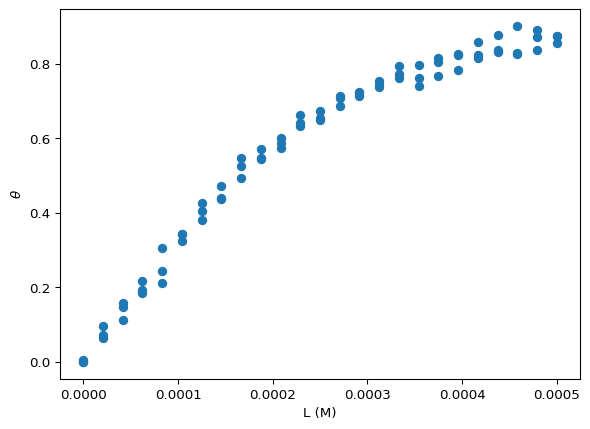

In [9]:
fig, ax = plt.subplots()

## Your task: Make a scatter plot (just points, no lines) of the data.  ##
ax.plot(df['L_(M)'], df['theta'], 'o')

## EXTRA: ##
## This adds x and y-axis labels. ##
ax.set_xlabel('L (M)')
ax.set_ylabel(r'$\theta$')
plt.show()

Put your estimate of $K_D$ in the cell below

In [11]:
## Your task: Assign your estimate of K_D to the variable below ##
K_D_estimate = 0.0001

#### (c) Fit and analyze.

Fit the data using the simple binding expression

$$
\theta = \frac{[L]}{[L] + K_D}
$$

Start by defining a function, called `simple_binding`, that calculates
this expression

In [13]:
## Your task: Define the function simple_binding that evaluates the equation ##
## from above. ##
def simple_binding(L, K_D):
    theta = L / (L + K_D)
    return theta

Then use that function to fit the data using `curve_fit`

In [15]:
## Your task: Set your estimate of K_D as the inital guess.
initial_guess = [K_D_estimate]

## Your task: Use curve_fit to find the fitted value of K_D
fitted_parameters, trash = curve_fit(simple_binding, df['L_(M)'], df['theta'], initial_guess)

## This extracts K_D and prints it ##
K_D_fit_simple = fitted_parameters[0]
print(K_D_fit_simple)

0.00013628483915769865

And evaluate the fit and plot it together with the dataset

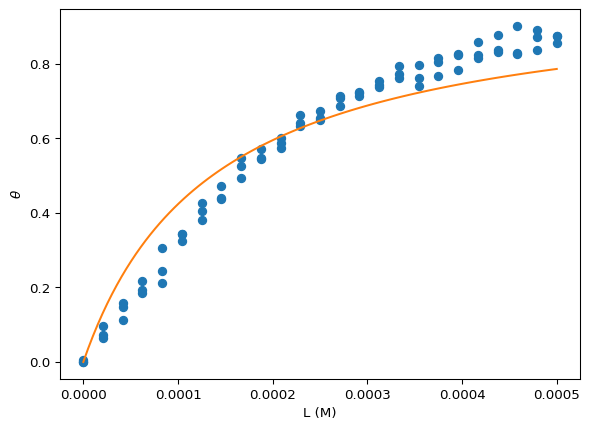

In [17]:
## Your task: Evaluate simple_binding using L_smooth and the value of K_D from your fit ##
L_smooth = np.linspace(0, 0.0005, 100)
theta_fit_simple = simple_binding(L_smooth, K_D_fit_simple)

fig, ax = plt.subplots()
## Your task: Plot the fit as line plot and the data as a scatter plot. ##
ax.plot(df['L_(M)'], df['theta'], 'o')
ax.plot(L_smooth, theta_fit_simple)

## EXTRA: 
## Labels for the axis.
ax.set_xlabel('L (M)')
ax.set_ylabel(r'$\theta$')
plt.show()

Is it a good fit?

#### (d) Residuals

To get a more quantitative view of the quality of the fit calculate
residuals

In [19]:
theta_model = simple_binding(df['L_(M)'], K_D_fit_simple)
residuals_simple = df['theta'] - theta_model

And plot them versus the measured $\mathrm{[L]}$

Text(0, 0.5, 'Residual')

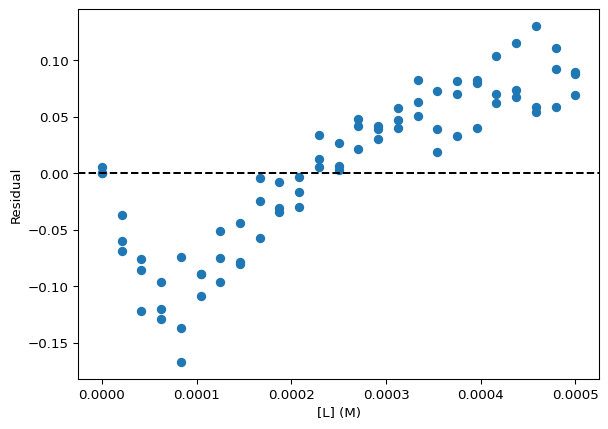

In [21]:
fig, ax = plt.subplots()

## Your task: Make a plot with residuals on the y-axis and L on the x-axis ##
ax.plot(df['L_(M)'], residuals_simple, 'o')

## This makes a horizontal line through 0 ##
ax.axhline(0, color='black', linestyle='--')

## EXTRA
## Adds axis labels. 
ax.set_xlabel('[L] (M)')
ax.set_ylabel('Residual')

Are the residuals randomly distributed around zero? What does this tell
you about the quality of the fit?

#### (e) Formulate a hypothesis

The protein concentration in the above titrations was 250 uM. Formulate
a hypothesis for why the fit fails.

#### (f) Choosing a better model

Next, we will try a fitting model that explicitly considers the
concentration of the protein being titrated. This is known as the
quadratic binding equation

$$
\begin{aligned}
\theta &= \frac{K_D + [P_{tot}] + [L_{tot}]}{2[P_{tot}]} - \sqrt{\left(\frac{K_D + [P_{tot}] + [L_{tot}]}{2[P_{tot}]}\right)^2 - \frac{[L_{tot}]}{[P_{tot}]}} \\
\end{aligned}
$$

The value of $[P_{tot}]$ is $250 \ \mu\mathrm{M}$.

Start by implementing the expression as a Python function - remember
that you need to be careful with parentheses with a function like this.

In [24]:
def quadratic_binding(L, K_D):    
    ## Your task: Set the protein concentration in appropriate units. ##
    P_tot = 250 * 10**(-6)

    ## Your task: Implement the quadratic binding equation ## 
    ## Be careful with parentheses! ##
    theta = (K_D + P_tot + L) / (2 * P_tot) - np.sqrt(((K_D + P_tot + L) / (2 * P_tot))**2 - L / P_tot)
    return theta

print(f"{quadratic_binding(100, 138.09) = :.3f}") # Should give 0.420

quadratic_binding(100, 138.09) = 0.420

And now make a fit using this expression

In [26]:
## Your task: Make a fit using the quadratic binding equation. ##
fitted_parameters, trash = curve_fit(quadratic_binding, df['L_(M)'], df['theta'])

## Extratcs and prints K_D ##
K_D_fit_quad = fitted_parameters[0]
print(K_D_fit_quad)

4.214239381928562e-05

The cell below makes a figure of the data and the residuals for each
fit. You are not expected to understand every line of code – the figure
is mainly to aid you interpretation of the data and show case how you
can make beautiful figures from you own data later on.

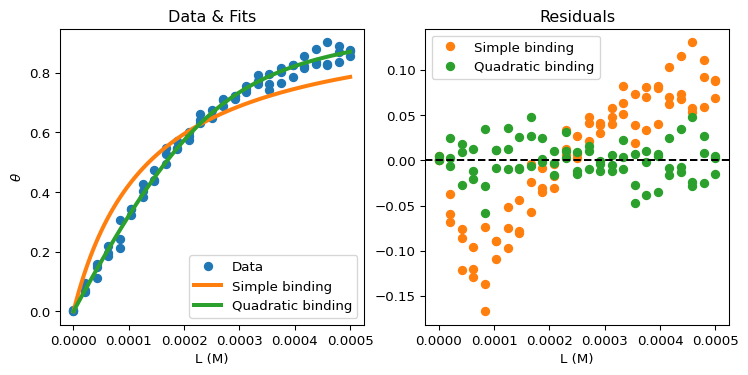

In [28]:
theta_fit_quad = quadratic_binding(L_smooth, K_D_fit_quad)
residuals_quad = df['theta'] - quadratic_binding(df['L_(M)'], K_D_fit_quad)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Data & Fit
ax = axes[0]
ax.plot(df['L_(M)'], df['theta'], 'o', label='Data')
ax.plot(L_smooth, theta_fit_simple, label='Simple binding', linewidth=3)
ax.plot(L_smooth, theta_fit_quad, label='Quadratic binding', linewidth=3)
ax.set_xlabel('L (M)')
ax.set_ylabel(r'$\theta$')
ax.set_title('Data & Fits')
ax.legend()

# Residuals
ax = axes[1]
ax.plot(df['L_(M)'], residuals_simple, 'o', color='C1', label='Simple binding')
ax.plot(df['L_(M)'], residuals_quad, 'o', color='C2', label='Quadratic binding')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Residuals')
ax.set_xlabel('L (M)')
ax.legend()

plt.show()

#### (g) Analyze

Consider the following questions:

-   How does the quadratic binding expression fit the data?
-   Whats the difference in how the residuals are distributed?
-   What is the biochemical situation that makes quadratic expression
    necessary?

------------------------------------------------------------------------

## 2 Determination of reaction orders.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

You have carried out a kinetic experiment investigating the turnover of
two metabolites, A1 and A2, in a cell lysate. For each metabolite, you
have measured the concentration of the compound as a function of time
using UV-Vis spectroscopy aiming to determine the reaction order, and
thus deduce something about the reaction mechanism by which they are
processed. The date from this experiment is found in
`reaction-orders.xlsx`.

#### (a) Load the dataset

Load the dataset `reaction-orders.xlsx` using the widget below

Run the next cell **after** uploading the file

In [33]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('reaction_order_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

51 rows × 3 columns

#### (b) SI units.

Add two new columns with the concentrations given in M.

In [35]:
df['A1_M'] = df['A1_uM'] * 10**(-6)
df['A2_M'] = df['A2_uM'] * 10**(-6)
display(df)

51 rows × 5 columns

#### (c) Plotting

For each reactant make a plot of the concentration versus time.

Text(0, 0.5, 'Concentration')

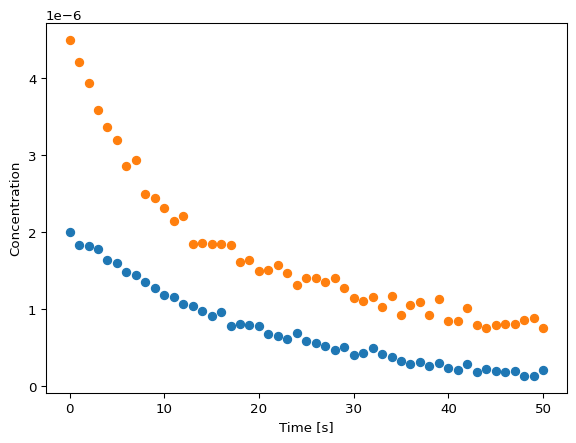

In [37]:
fig, ax = plt.subplots() 

## Your task: Make plots of concentration (y) versus time (x). ##
## Hint: ax.plot(x_data, y_data, 'o') to make a scatter plot. ##
ax.plot(df['Time_s'], df['A1_M'], 'o')
ax.plot(df['Time_s'], df['A2_M'], 'o')

## EXTRA: Customization of axis labels ##
ax.set_xlabel('Time [s]')
ax.set_ylabel('Concentration')

#### (d) Model as N’th-order reaction

We will model the reactions as zeroth, first and second order. We will
consider both the the rate constant $k$ and the concentration at time
$t = 0$ parameters of the fit.

In [39]:
def zeroth_order(t, k, A0):
    ## Your task: Implement the zeroth order rate equation ##
    result = A0 - k*t
    return result

def first_order(t, k, A0):
    ## Your task: Implement the first order rate equation ##
    result = A0 * np.exp(-k*t)
    return result

def second_order(t, k, A0):
    ## Your task: Implement the second order rate equation ##
    result = A0 / (1 + 2*k*t*A0)
    return result

## Use these to check that your functions are correct!  
print('zeroth_order', zeroth_order(1, 1, 2)) # Should give 1
print('first_order', first_order(1, 1, 2)) # Should give 0.7357...
print('second_order', second_order(1, 1, 2)) # Should give 0.4

zeroth_order 1
first_order 0.7357588823428847
second_order 0.4

Then we can make a fit to measurements of each reactant.

In [41]:
## Your task: Pick a rate equation and assign it to the variable rate_equation
## You can change this to first_order or second_order
## Do not call the function - so no (...) just assign it to the variable.
rate_equation = zeroth_order

## Your task: Make a fit of the A1_M data with 'rate_equation'.
fitted_parameters_A1, trash = curve_fit(rate_equation, df['Time_s'], df['A1_M'])    
k_A1_fit = fitted_parameters_A1[0]
A1_0_fit = fitted_parameters_A1[1]

## Your task: Make a fit of the A2_M with 'rate_equation'.
fitted_parameters_A2, trash = curve_fit(rate_equation, df['Time_s'], df['A2_M'])
k_A2_fit = fitted_parameters_A2[0]
A2_0_fit = fitted_parameters_A2[1]

## Prints the found parameters
print(k_A1_fit)
print(A1_0_fit)

print(k_A2_fit)
print(A2_0_fit)

3.390184293164445e-08
1.5887604659704164e-06
5.786947687397643e-08
3.148604267116672e-06

Now that we fitted the data using one of the rate equations, we can plot
to see how well it fits

Text(0, 0.5, 'Concentration')

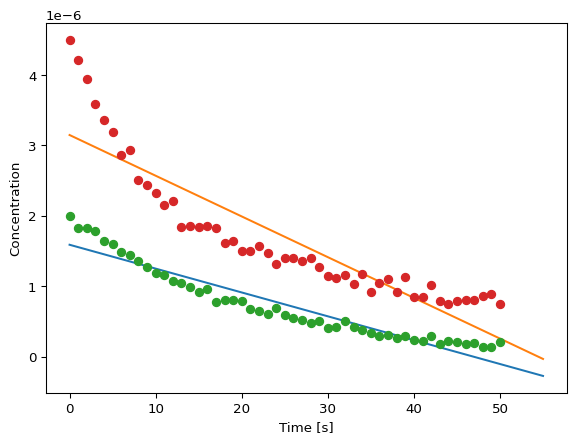

In [43]:
fig, ax = plt.subplots() 

## Your task: Finish the code to calculate the fit for A2.
t_smooth = np.linspace(0, 55)
A1_fit = rate_equation(t_smooth, k_A1_fit, A1_0_fit)
A2_fit = rate_equation(t_smooth, k_A2_fit, A2_0_fit)

## Your task: Plot the fits 
ax.plot(t_smooth, A1_fit)
ax.plot(t_smooth, A2_fit)

## Plots the data ##
ax.plot(df['Time_s'], df['A1_M'], 'o')
ax.plot(df['Time_s'], df['A2_M'], 'o')

## EXTRA: Customization of axis labels ##
ax.set_xlabel('Time [s]')
ax.set_ylabel('Concentration')

Once you’ve finished the fitting with one of the rate equations you can
go back and change the `rate_equation` variable to try one of the
others.

#### (e) Determining reaction orders

The cell below makes a plot for each rate law in the same panel using
your defined rate equations.

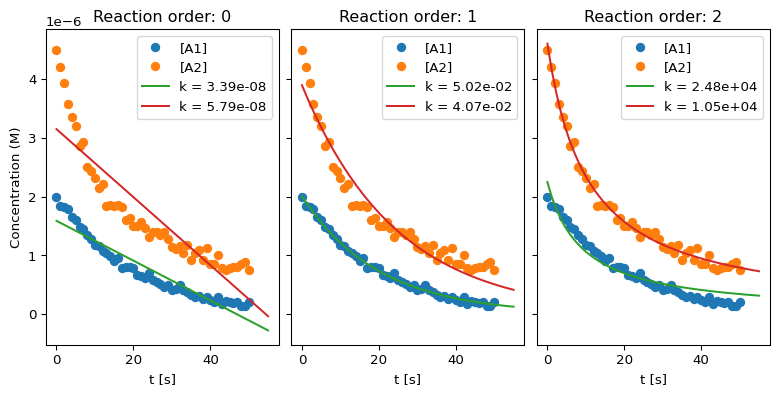

In [45]:
from fysisk_biokemi.utils.deter_reacti_orders import make_plot
rate_laws = {0: zeroth_order, 1: first_order, 2: second_order}
make_plot(df, rate_laws)

Based on this plot;

1.  What is the reaction order for \[A1\]?
2.  What is the unit of the rate constant for \[A1\]?
3.  What is the reaction order for \[A2\]?
4.  What is the unit of the rate constant for \[A2\]?

#### (f) Reaction mechanism

What does the above tell you about the reaction mechanism whereby the
two compounds disappear from the lysate?

------------------------------------------------------------------------

## 3 Analysis of a reversible reaction

In [48]:
import matplotlib.pyplot as plt
import numpy as np

Consider the following reaction

$$
A \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} B
$$

The magnitudes of the rate constants are $k_1 = 10 \ \mathrm{s}^{-1}$
and $k_2 = 1 \ \mathrm{s}^{-1}$.

#### (a) Reaction order

What is the reaction order in each direction?

#### (b) Derive equilibrium constant

Show mathematically how the equilibrium constant $K_{\mathrm{eq}}$ is
given by the ratio between the two rate constants.

#### (c) Calculate $K_{\mathrm{eq}}$

In [52]:
## Your task: Assign known values & calculate the equilibrium constant.
k1 = 10 
k2 = 1
K_eq = k1 / k2
print(K_eq)

10.0

#### (d) Equilibrium concentrations

Calculate the concentrations of A and B at equilibrium,
$[\mathrm{A}]_{\mathrm{eq}}$ and $[\mathrm{B}]_\mathrm{eq}$, if
$[\mathrm{A}]_0 = 10^{-3} \text{M}$

In [54]:
A0 = 10**(-3)
A_eq = (k2 * A0) / (k1 + k2)
B_eq = (k1 * A0) / (k1 + k2)
print(A_eq)
print(B_eq)

9.090909090909092e-05
0.0009090909090909091

#### (e) Initial rate of formation

If $[\mathrm{A}]_0 = 10^{-3} \ \text{M}$ and
$[\mathrm{B}]_0 = 0 \ \text{M}$, calculate the initial rate of formation
of B.

In [56]:
## Your task: Calculate initial rate of formation of B
r_fwd = A0 * k1
print(r_fwd)

0.01

#### (f) Time-dependence

![](https://raw.githubusercontent.com/au-mbg/fysisk-biokemi/refs/heads/main/course/lessons/figures/week_48/reversible_reaction.png)

We now want to calculate and plot the time-dependent concentrations
using the above equations.

In the cell below finish the implementation of the function `A_time`
that calculates the concentration \[A\] as a function of time.

In [58]:
## Your task: Implement the function to calculate the time dependent concentration.
## Be careful with parentheses.
def A_time(t, A0, k_f, k_b):
    A_t = (k_b + k_f * np.exp(-(k_f+k_b)*t)) / (k_f + k_b) * A0
    return A_t


test = A_time(1, 1, 1, 1)
print(test) # This should give 0.567...

0.5676676416183064

And then we can use that function to calculate and plot the
concentrations as a function of time. As you have seen above, the
reaction is pretty fast, so we will just focus on the first second

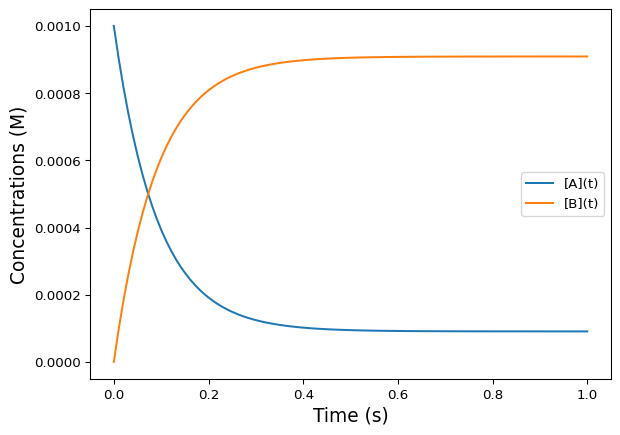

In [60]:
fig, ax = plt.subplots()
t = np.linspace(0, 1, 100)

## Your task: Calculate [A](t) and [B](t) ##
At = A_time(t, A0, k1, k2)
Bt = A0 - At

## Plots the concentrations versus time.
ax.plot(t, At, label='[A](t)')
ax.plot(t, Bt, label='[B](t)')

## EXTRA: Sets x and y-axis labels. 
ax.set_ylabel('Concentrations (M)', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=14)
ax.legend()

------------------------------------------------------------------------

## 4 Determination of reaction order and activation energy

In [61]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
from scipy.optimize import curve_fit
pd.set_option('display.max_rows', 6)

The irreversible isomerization of compound A to compound B results in a
decreasing absorbance. The isomerization was followed in a time course
at two different temperatures (T1 = 25 °C and T2 = 40 °C). The
absorbance ($\epsilon$ = 16700 $\mathrm{cm}^{-1} \mathrm{M}^{-1}$) was
used to calculate the concentration of compound A in a spectrophotometer
with a pathlength of 1 cm. The obtained dataset is given in the file
`deter-reacti-order-activ.csv`.

#### (a) Temperatures

What are the two temperatures in Kelvin? Set them as varilabes in the
cell below.

In [63]:
## Your task: Convert the temperatures to K and assign to the variables:
T1 = 25 + 273.15
T2 = 40 + 273.15

#### (b) Load the dataset

Load the dataset using the widget below

In [64]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [65]:
df = uploader.get_dataframe()
display(df)

In [66]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('reaction_order_activation_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

26 rows × 3 columns

#### (c) SI Units

Calculate the concentration of A at each timepoint in SI units, by
adding new columns to the `DataFrame`.

In [68]:
## Your task: Assign known values ##
extinction_coeff = 16700 
L = 1 # Path length

## Calculate concentrations using the variables above and the data in the dataframe ##
df['[A]_(M)_25C'] = df['Abs(t)_25C'] / (extinction_coeff * L)
df['[A]_(M)_40C'] = df['Abs(t)_40C'] / (extinction_coeff * L)
display(df)

26 rows × 5 columns

#### (d) Plot the data

We will be resuing the plot, so we will put the code for it in a
function.

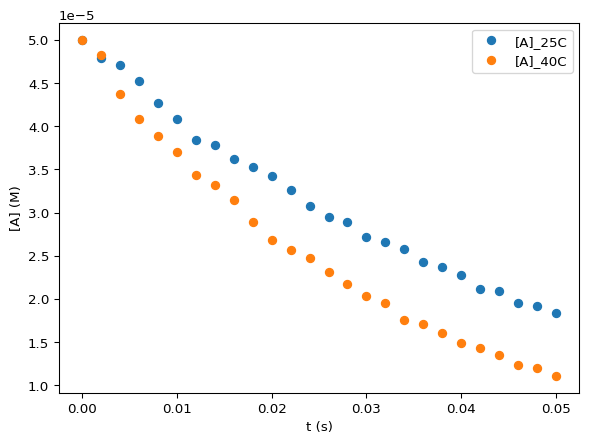

In [70]:
fig, ax = plt.subplots()

# Task: Plot the two data series in a scatter plot
# That is: t_(s) vs [A]_(M)_25C 
# and: t_(s) vs [A]_(M)_40C
ax.plot(df['t_(s)'], df['[A]_(M)_25C'], 'o', label='[A]_25C')
ax.plot(df['t_(s)'], df['[A]_(M)_40C'], 'o', label='[A]_40C')

## EXTRA: This sets x and y-axis labels and shows the legends.
ax.set_xlabel('t (s)')
ax.set_ylabel('[A] (M)')
ax.legend()

#### (e) Fitting with rate equations

Now want to fit the data using integrated rate laws - in order to
ultimately determine the reaction orders of the two datasets.

To do so we need functions for zeroth, first and second order integrated
rate laws.

In [72]:
def zeroth_order(t, k, A0):
    ## Your task: Implement the zeroth order rate equation ##
    result = A0 - k*t
    return result

def first_order(t, k, A0):
    ## Your task: Implement the first order rate equation ##
    result = A0 * np.exp(-k*t)
    return result

def second_order(t, k, A0):
    ## Your task: Implement the second order rate equation ##
    result = A0 / (1 + 2*k*t*A0)
    return result

## Use these to check that your functions are correct!  
print('zeroth_order', zeroth_order(1, 1, 2)) # Should give 1
print('first_order', first_order(1, 1, 2)) # Should give 0.7357...
print('second_order', second_order(1, 1, 2)) # Should give 0.4

zeroth_order 1
first_order 0.7357588823428847
second_order 0.4

Having defined these functions we can use them for fitting

In [74]:
## Task: Choose one of the rate equations and assign to the variable
rate_equation = first_order

## Task: Fit to the data at 25 C
fitted_parameters_25C, trash = curve_fit(rate_equation, df['t_(s)'], df['[A]_(M)_25C'])

## Task: Fit to the data at 40 C
fitted_parameters_40C, trash = curve_fit(rate_equation, df['t_(s)'], df['[A]_(M)_40C'])

## Extracts & prints the parameters
k_25C, A0_25C = fitted_parameters_25C
k_40C, A0_40C = fitted_parameters_40C

print(k_25C, A0_25C)
print(k_40C, A0_40C)

20.081750693534495 5.024371022380773e-05
29.96091632105259 4.990085394734088e-05

Having made the fits we plot it together with the two data series.

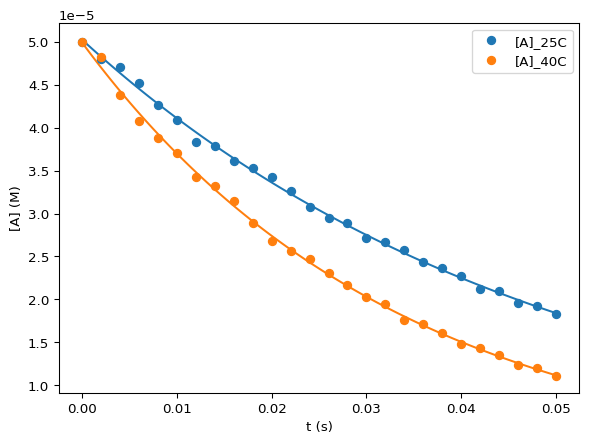

In [76]:
## Your task: Calculate the fits using the chosen rate equation & 
## the found parameters found during fitting.
t_smooth = np.linspace(0, 0.05, 100)
A_fit_25C = rate_equation(t_smooth, k_25C, A0_25C)
A_fit_40C = rate_equation(t_smooth, k_40C, A0_40C)

fig, ax = plt.subplots()

## Your task: Plot the two fits
ax.plot(t_smooth, A_fit_25C)
ax.plot(t_smooth, A_fit_40C)

## This plots the data sets
ax.plot(df['t_(s)'], df['[A]_(M)_25C'], 'o', label='[A]_25C', color='C0')
ax.plot(df['t_(s)'], df['[A]_(M)_40C'], 'o', label='[A]_40C', color='C1')

## EXTRA: Sets the axis labels and legend.
ax.set_xlabel('t (s)')
ax.set_ylabel('[A] (M)')
ax.legend()

You can go back to the cell where you set `rate_equation` and use
another of the three: `zeroth_order`, `first_order`, `second_order`.

#### (f) Determine reaction order

Based on your analysis above or by using the plot the created by the
next cell determine the reaction order and the units of the rate
constant for each of the two reactions.

The function makes the same fits that you made, but makes them all at
once and plots the results side by side.

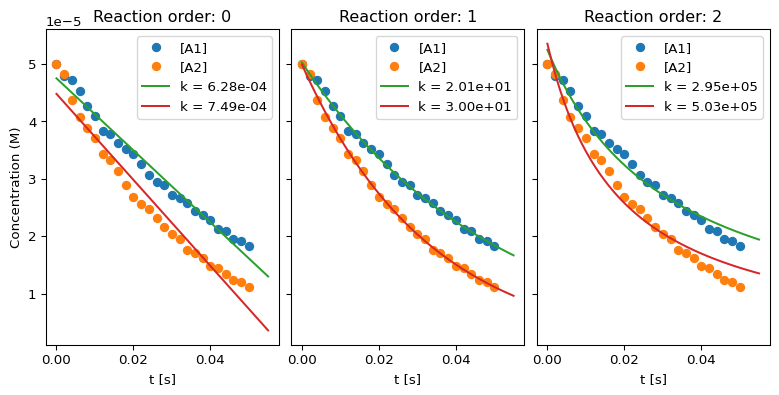

In [78]:
from fysisk_biokemi.utils.deter_reacti_order_activ import make_plot
rate_laws = {0: zeroth_order, 1: first_order, 2: second_order}
make_plot(df, rate_laws)

> **Information on ‘make_plot’**
>
> The function ‘make_plot’ is beyond what is expected for this course,
> however if you are interested you can see the source code for it on
> [github](https://github.com/au-mbg/fysisk-biokemi/blob/main/src/fysisk_biokemi/utils/deter_reacti_order_activ.py).

#### (g) Activation energy

With the assumption that the Arrhenius constant $A$ and the activation
energy are temperature independent in the interval measured, use the
Arrhenius equation to calculate the activation energy of the
isomerization of the compound A.

You can use
$R = 8.314 \times 10^{-3} \ \frac{\text{kJ}}{\text{mol} \cdot \text{K}}$

> **Caution**
>
> You need to derive the correct equation **before** using Python to
> calculate the result.

Perform the calculation in the cell below.

In [81]:
## Your task: Define known & fitted values
k1 = 20.08175
k2 = 29.96091
R = 8.318 * 10**(-3) # kJ / (mol K)

## Your task: Calculate the activation energy
## Remember: Derive the correct formula first using pen and paper!
activation_energy = R * np.log(k1/k2)/(1/T2 - 1/T1) # kJ/mol
print(activation_energy)

20.71400117402973

------------------------------------------------------------------------

## 5 The pH effect on an active site histidine residue

Assume that a compound R can react with the unprotonated form of
Histidine, $\text{His}$, to form a covalent reaction product,
$\text{P}$: $$
\text{His} + \text{R} \rightarrow \text{P}
$$

The protonated form of Histidine, $\text{HisH}^+$, is in equilibrium
with $\text{His}$:

$$
\text{HisH}^+ \rightleftharpoons \text{His} + \text{H}^+
$$

The pKa value for this acid-base equilibrium is 6.0. Further assume that
the total concentration of Histidine, is

$$
[\text{HisH}^+] + [\text{His}] = 10^{-3} \ \text{M}
$$

#### (a) Percentage unprotonated

What percentage of Histidine is unprotonated at pH 6.0. What do you
notice about the relationship between pH and pKa in this case? (You
should not need to do any arithemtic or algebra to answer this
exercise.)

In [84]:
## Your task: What percentage is unprotonated? 
percentage_unprotonated = 50

#### (b) Concentration

Determine $[\text{His}]$ at pH 6

In [87]:
## Your task: Assign known value and calculate [His]
total_conc = 10**(-3)
his_conc = total_conc * percentage_unprotonated / 100 # Unit: M
print(his_conc)

# Or directly 
his_conc = 0.5 * 10**(-3) # Unit: M
print(his_conc)

0.0005
0.0005

#### (c) Reaction order

The reaction equation for the reaction between $\text{His}$ and
$\text{R}$ is

$$
v = - \frac{d[\text{His}]}{dt} = k \cdot [\text{His}] \cdot [\text{R}]
$$

What’s the reaction order?

#### (d) High concentrations

If $[\text{R}]$ is much higher than $[\text{His}]$, what can then be
concluded regarding the order of the reaction?

#### (e) New rate constant

Show how a new rate constant, $k'$, can be defined in these conditions.
How does $k'$ depend on $\text{R}$?

#### (f) SI Units

At pH 6.0 the reaction rate $v = 1 \ \text{mM}\cdot \text{s}^{-1}$.

Convert the reaction rate to SI-units given in
$\text{M}\cdot \text{s}^{-1}$.

In [92]:
# Your task: Calculate v in SI units M / s
reaction_rate = 1 * 10**(-3) # Units: M / s
print(reaction_rate)

0.001

#### (g) Calculate the rate constant

Use the concentration of $[\text{His}]$ at pH 6 calculated in question
(b), the reaction rate from (f) and constant
$[\text{R}] = 0.2 \ \text{M}$ to calculate the rate constant $k$.

In [94]:
## Your task: Set known value and calculate k ##
## Hint: You can use the his_conc variable ##
R_conc = 0.2
k = reaction_rate / (R_conc * his_conc)
print(k)

10.0

------------------------------------------------------------------------

## 6 Qualitative description of Michaelis-Menten kinetics

In [95]:
import plotly
import fysisk_biokemi.widgets as fbw
from fysisk_biokemi.widgets.utils import enable_custom_widget_colab, disable_custom_widget_colab
from IPython.display import display, HTML
enable_custom_widget_colab()

In [96]:
fbw.michaelis_menten_demo()

Use the widget created by the cell above to answer the following the
questions.

#### (a) Change $K_M$

Setting $V_\mathrm{max} = 400$ and $[E]_\mathrm{tot} = 0.0005$, change
$K_M$ from 0.5 to 5 to 10 to 50. Describe the change in curve appearance
and explain it using the Michaelis-Menten (MM) equation.

#### (b) Meaning of $K_M$

What is the biochemical meaning of $K_M$?

#### (c) Change $V_\mathrm{max}$ and $[E]_\mathrm{tot}$

Now set $[E]_\mathrm{tot} = 0.0005$, and $K_M = 5$. Change
$V_\mathrm{max}$ step-wise from 40 to 900. Describe the changes you
observe and how they relate to the MM equation.

After this, repeat the procedure for $[E]_\mathrm{tot}$ increasing it
10-fold.

#### (d) Substrate concentrations way below \$K_M

Next, we will explore the regime where $[S] \gg K_M$. Initially, set
$K_M = 10$ and zoom in on the regime from $0$ to $1$ on the X-axis. What
does the MM equation look like in this regime? Use the MM equation and a
simplifying assumption to show how this occurs.

Next, increase $K_M$ five-fold and try to change $V_\mathrm{max}$ som
the curve appearance is unchanged (beware of the autoscaling Y-axis).

Imagine an experiment conducted using only $[S]$ values from this range.
How would this affect how well you could determine the MM parameters?

#### (f) Training estimation skills.

Train your estimation skills using the widget below.

In [97]:
fbw.michealis_menten_guess()

------------------------------------------------------------------------

## 7 Design of an enzyme kinetics experiment

In [98]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

We have finally arrived at the part of the course where we are ready to
analyse the data from your lab exercise in the first quarter. First,
however we will analyse a similar data set where we are sure about the
data quality (😉) to illustrate the process.

In the Excel document `design-enzyme-kineti-exper.xlsx` you will find a
data set in which an enzyme catalyzed formation of product P, with
varying start concentration of substrates, \[S\], was followed over
time. The product absorbs light at a specific wavelength with an
extinction coefficient of 0.068 $\mu\text{M}^{-1}\cdot \text{cm}^{-1}$,
and the absorbance was measured in a light path of 1 cm throughout the
time course.

You can load the dataset using the cells below;

In [99]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [100]:
df = uploader.get_dataframe()
display(df)

In [101]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('design-enzyme-kineti-exper.xlsx') # Load from package for the solution so it doesn't require to interact.
display(df)

21 rows × 10 columns

The headers, like `Abs_S1` refer to the substrate concentration so `S1`
means a substrate concentration of 1 $\mu\text{M}$.

#### (a) Connvert extinction coefficient to SI.

Convert the extinction coefficient to units given in
$\text{M}^{-1}\cdot \text{cm}^{-1}$ and assign it to a variable. Also
assign the light path length to a variable.

In [103]:
## Your task: Assign known values in SI units.
ext_coeff = 0.068 / 10**(-6) # 1/(M cm)
l = 1 # cm

#### (b) Calculate concentrations

Using Lambert-Beers law, calculate the concentration of product, $[P]$,
in $\text{M}$ for each time series.

The cell below setups a loop calculate the concentrations for each of
these current columns in the dataframe.

In [105]:
## Your task calculate the concentration for each 'Abs_SX' column and add it ##
## as a new column. 
df['C_S1'] = df['Abs_S1'] / (ext_coeff * l)
df['C_S2'] = df['Abs_S2'] / (ext_coeff * l)
df['C_S4'] = df['Abs_S4'] / (ext_coeff * l)
df['C_S8'] = df['Abs_S8'] / (ext_coeff * l)
df['C_S16'] = df['Abs_S16'] / (ext_coeff * l)
df['C_S32'] = df['Abs_S32'] / (ext_coeff * l)
df['C_S64'] = df['Abs_S64'] / (ext_coeff * l)
df['C_S128'] = df['Abs_S128'] / (ext_coeff * l)
df['C_S256'] = df['Abs_S256'] / (ext_coeff * l)

In [107]:
for s in [1, 2, 4, 8, 16, 32, 64, 128, 256]: 
    df[f'C_{s}'] = df[f'Abs_S{s}'] / (ext_coeff * l)

And we can check that the columns we expect have been added to the
`DataFrame`.

In [109]:
display(df)

21 rows × 19 columns

#### (c) Plot

We focus now on the `C_S32`-column and plot it versus the time
measurements.

Text(0, 0.5, 'Concentration (M)')

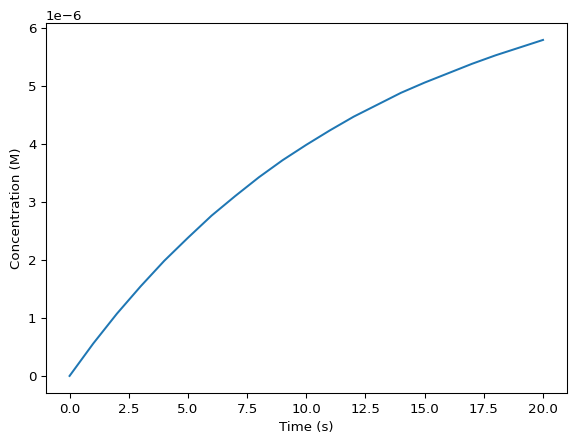

In [111]:
fig, ax = plt.subplots()

## Your task: Plot the C_S32 column 
ax.plot(df['time_(s)'], df['C_S32'])

## EXTRA: 
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration (M)')

#### (d) Extracting $V_0$.

In enzyme kinetics, we usually focus on the initial time points,
i.e. before the reaction has progressed far enough to allow products to
be accumulated and substrate to be depleted. In this early stage of the
reaction, we know that the concentration has not changed significantly
yet and thus the \[S\] = S0. Therefore, the reaction time course tends
to be linear in this range.

In the following, we want to just fit the initial part of the curve. We
do this by defining a new data array containing only the first values.

We want to use Python to determine $V_0$ for each concentration of $S$,
in order to create a table of $V_0$ vs $[S]$. To do so we will fit
linear functions to the initial parts of the curves, as the slope of
these is then $V_0$.

Start by defining a linear function;

In [113]:
def linear_func(x, a, b):
    return a * x + b

As mentioned we want to to get the slope in the initial part of the
reaction, where the curves are approximately linear. To do so we need to
fit not on all the data-points but only some of them.

We will first do this for the `C_S32`-column.

In [115]:
## Determine the x and y data
x_data_full = df['time_(s)']
y_data_full = df['C_S32']

## Your task: Set n_points to choose the number of points to fit with
n_points = 5
x_data = x_data_full[0:n_points] # This picks the first n_points points.
y_data = y_data_full[0:n_points] # This picks the first n_points points.

## Your task: Make the fit.
fitted_parameters, trash = curve_fit(linear_func, x_data, y_data)
a, b = fitted_parameters

The cell below plots your fit alongside the data

Text(0, 0.5, 'Concentration')

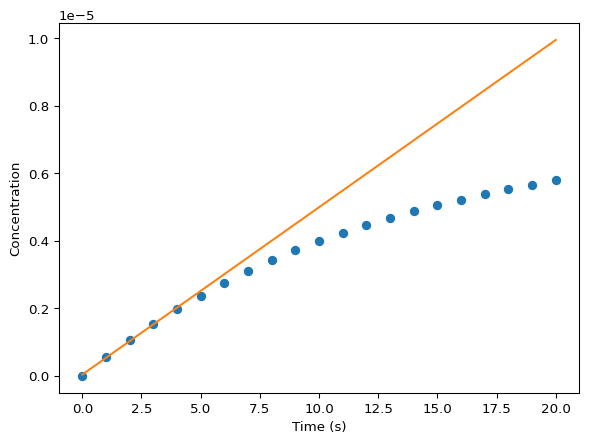

In [117]:
fig, ax = plt.subplots()
t_smooth = np.linspace(0, 20)
y_fit = linear_func(t_smooth, a, b)
ax.plot(x_data_full, y_data_full, 'o')
ax.plot(t_smooth, y_fit)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration')

You want the line to fit well with the initial approximately linear part
of the data, adjust `n_points` such that this is the case.

#### (e) Using all the datasets

In the cell below `n_points` again determines the number of data-points
used for the linear fit, and makes the fits and plots for every dataset.

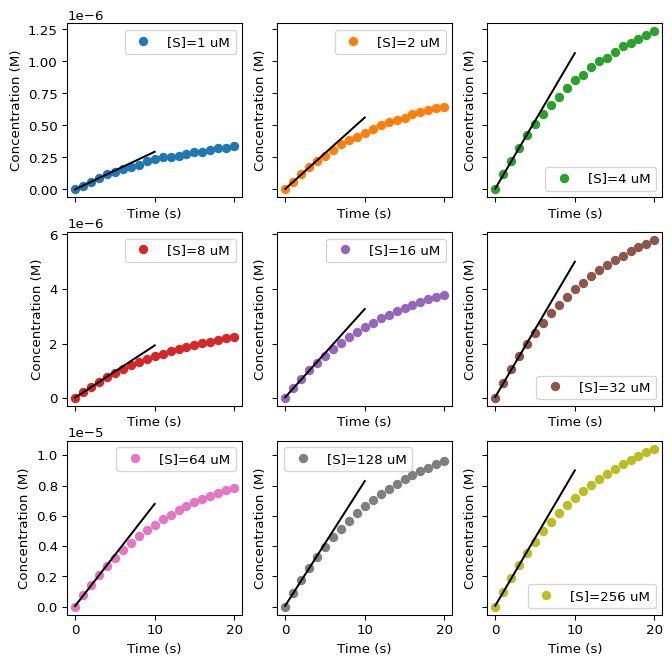

In [119]:
from fysisk_biokemi.utils.design_enzyme_kineti_exper import make_fits_and_plots

## Your task: Select a number of points to fit with that is appropriate in 
## all cases
n_points = 5

## This function does what you did in the previous exercise but for all the datasets. ##
slopes, concentrations = make_fits_and_plots(df, n_points)

> **Information on ‘make_fits_and_plot’**
>
> The function ‘make_fits_and_plots’ is beyond what is expected for this
> course, however if you are interested you can see the source code for
> it on
> [github](https://github.com/au-mbg/fysisk-biokemi/blob/main/src/fysisk_biokemi/utils/design_enzyme_kineti_exper.py).

Once you’re satisfied with the fit you can display the collected slopes
with the cell below

In [121]:
V0_df = pd.DataFrame({'[S]_(M)': concentrations, 'V0_(M/s)': slopes})
display(V0_df)

9 rows × 2 columns

#### (f) Understanding of $V_0$

Why is it important to use $V_0$ rather than $V$ at a later time point
when creating the Michaelis-Menten plot?

#### (g) Plotting again.

Plot $V_0$ against substrate concentration and estimate $k_{cat}$ and
$K_M$ visually (remember units)

Text(0, 0.5, '$V_0$ (M/s)')

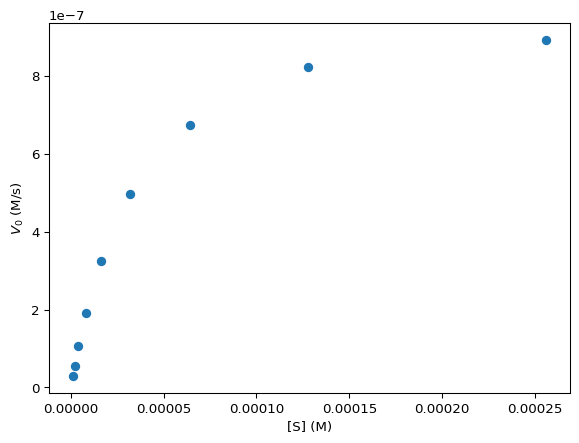

In [124]:
fig, ax = plt.subplots()

# Your task: Plot the V0_(M/s) versus [S_(M)]
ax.plot(V0_df['[S]_(M)'], V0_df['V0_(M/s)'], 'o')

## EXTRA: Axis labels.
ax.set_xlabel('[S] (M)')
ax.set_ylabel('$V_0$ (M/s)')

Use the figure to estimate the value of $K_M$ and $V_\text{max}$ and put
those in the cell below.

In [126]:
# Your task: Put your estimated values here: 
K_M_estimate = 30 * 10**(-6)
V_max_estimate = 10 * 10**(-7)

#### (h) Fitting with Michealis-Menten

Now we can fit with the Michealis-Menten equation, as always in a
fitting task we need to implement the model.

In [128]:
def michaelis_menten(S, K_M, V_max):
    ## Your task: Implement the Michaelis-Menten model.
    result = (V_max * S) / (K_M + S)
    return result

Then use the next two cells to make the fit and plot it.

In [130]:
## Uses your estimate as initial guess
initial_guess = [K_M_estimate, V_max_estimate]
fitted_parameters, trash = curve_fit(michaelis_menten, V0_df['[S]_(M)'], V0_df['V0_(M/s)'], initial_guess)

## Extract and prints the parameters
K_M_fit, V_max_fit = fitted_parameters
print(K_M_fit)
print(V_max_fit)

3.402856184164823e-05
1.0245295933534427e-06

How do these compare to your estimates of the two parameters?

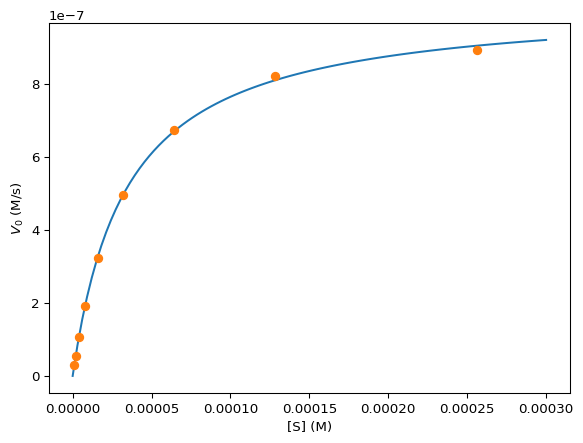

In [132]:
fig, ax = plt.subplots()

## Evaluates the fit
S_smooth = np.linspace(0, 0.0003, 100)
V0_fit = michaelis_menten(S_smooth, K_M_fit, V_max_fit)

## Plots the fit and the data.
ax.plot(S_smooth, V0_fit)
ax.plot(V0_df['[S]_(M)'], V0_df['V0_(M/s)'], 'o')

## Axis labels.
ax.set_xlabel('[S] (M)')
ax.set_ylabel('$V_0$ (M/s)');

------------------------------------------------------------------------

## 8 Lab Exercise Analysis: Michaelis Menten

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display

In the “Introduction to the Molecules of Life” course, you performed an
experiment where you measured absorption for different substrate
concentrations as a function of time. The experiment was done with
p-nitrophenylphosphate as the substrate, which turns into p-nitrophenol
when the enzyme (alkaline phosphatase) acts on it.

If you do not have data, or you find that your data set is not of
sufficient quality, you can use the following `kinetics_data.xlsx`.

Load your dataset using the widget below

In [134]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [135]:
df = uploader.get_dataframe()
display(df)

In [136]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('kinetics_LØ') # Load from package for the solution so it doesn't require to interact.
display(df)

19 rows × 9 columns

#### (a) Absorbance to concentration

The measured absorbances are unitless, they are the log of the ratio
between the incoming light intensity and the transmitted light
intensity. We would like to work with concentrations instead, so we need
to convert the absorbance to concentration. The conversion is done using
Lambert-Beer’s law.

The extinction coefficient of the product p-nitrophenol is
$\varepsilon = 18000 \, \text{M}^{-1} \text{cm}^{-1}$ at
$405 \ \text{nm}$ and the path length of the cuvette is
$l = 1\, \text{cm}$. We will construct a new `DataFrame` with
concentrations

We will start by defining a function `lambert_beers` to calculate the
concentrations

In [138]:
def lambert_beers(absorbance):
    ## Your task: Finish the implementation of LBs-law to calculate concentrations.
    L = 1 # cm
    ext_coeff = 18000 # 1 / (M cm)
    conc = absorbance / (L * ext_coeff) # M 
    return conc

The next cell makes a new `DataFrame` by applying the lambert_beers
function to every column in the original

In [140]:
data = {
    'time': df['time'],
    'S_0.8_mM': lambert_beers(df['0.8']),
    'S_0.4_mM': lambert_beers(df['0.4']),
    'S_0.2_mM': lambert_beers(df['0.2']),
    'S_0.12_mM': lambert_beers(df['0.12']),
    'S_0.05_mM': lambert_beers(df['0.05']),
    'S_0.02_mM': lambert_beers(df['0.02']),
    'S_0.01_mM': lambert_beers(df['0.01']),
    'S_0.003_mM': lambert_beers(df['0.003']),
}

df = pd.DataFrame(data)
display(df)

19 rows × 9 columns

#### (b) Plot

Now let’s plot the data. Plot each column separately as a function of
time.

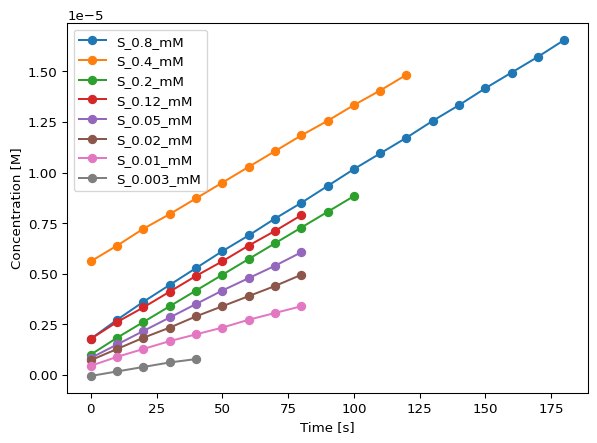

In [142]:
fig, ax = plt.subplots()

# Your task: Plot concentration vs. time for each column of the dataset, 
# So 8 lines of code total.
ax.plot(df['time'], df['S_0.8_mM'], '-o', label='S_0.8_mM')
ax.plot(df['time'], df['S_0.4_mM'], '-o', label='S_0.4_mM')
ax.plot(df['time'], df['S_0.2_mM'], '-o', label='S_0.2_mM')
ax.plot(df['time'], df['S_0.12_mM'], '-o', label='S_0.12_mM')
ax.plot(df['time'], df['S_0.05_mM'], '-o', label='S_0.05_mM')
ax.plot(df['time'], df['S_0.02_mM'], '-o', label='S_0.02_mM')
ax.plot(df['time'], df['S_0.01_mM'], '-o', label='S_0.01_mM')
ax.plot(df['time'], df['S_0.003_mM'], '-o', label='S_0.003_mM')

ax.set_xlabel('Time [s]')
ax.set_ylabel('Concentration [M]')
ax.legend()
plt.show()

#### (c) Finding the slopes

In order to apply the Michaelis Menten equation we need the slopes of
these curves as that is the reaction velocity $V_0$, luckily we have
learned how to make fits! So we make a fit to the linear function to
determine the slope $a$ in, $$
y(x) = a x + b
$$ As always, start by writing the function

In [144]:
def linear_function(x, a, b):
    ## Your task: Implement the linear function
    result = ...
    return result

In [145]:
def linear_function(x, a, b):
    ## Your task: Implement the linear function
    result = a * x + b
    return result

Now we want to find the slope for each column, to help with that we will
introduce a function that takes the time column and one of the
concentration columns and returns the slope

In [147]:
def find_slope(time_data, abs_data):

    ## This selects the times and absorbances that have been measured (not NaN)
    ## Don't worry about this - this is just to help you with this exercise.
    indices = np.where(~abs_data.isna())[0]
    time_data = time_data[indices]
    abs_data = abs_data[indices]

    ## Find the slope and the intercept using curve_fit and return the slope
    fitted_parameters, trash = curve_fit(linear_function, time_data, abs_data)
    slope = fitted_parameters[0]
    return slope

Now we want to use this for each set of measurements at different
substrate concentrations.

In [149]:
## Your task: Find the slopes for every substrate concentration.
slope_08 = find_slope(df['time'], df['S_0.8_mM'])
slope_04 = find_slope(df['time'], df['S_0.4_mM'])
slope_02 = find_slope(df['time'], df['S_0.2_mM'])
slope_012 = find_slope(df['time'], df['S_0.12_mM'])
slope_005 = find_slope(df['time'], df['S_0.05_mM'])
slope_002 = find_slope(df['time'], df['S_0.02_mM'])
slope_001 = find_slope(df['time'], df['S_0.01_mM'])
slope_0003 = find_slope(df['time'], df['S_0.003_mM'])

## This gathers the slopes and makes an array with the substrate concentrations.
substrate_concentrations = np.array([0.8, 0.4, 0.2, 0.12, 0.05, 0.02, 0.01, 0.003]) * 10**(-3)
slopes = np.array([slope_08, slope_04, slope_02, slope_012, slope_005, slope_002, slope_001, slope_0003])

Now make a plot of the slopes versus the substrate concentrations using
the two arrays `substrate_concentrations` and `slopes`.

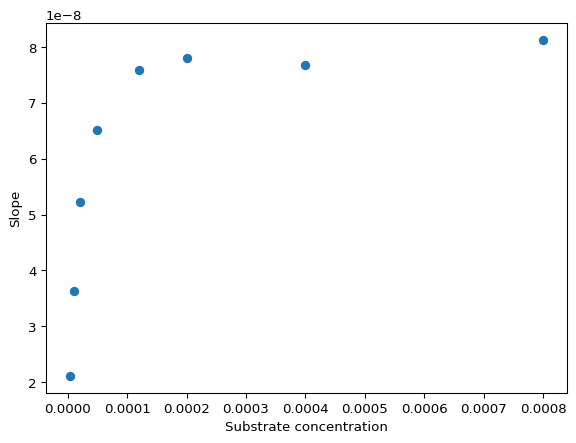

In [151]:
fig, ax = plt.subplots() 

## Your task plot the slopes vs. substrate concentration.
ax.plot(substrate_concentrations, slopes, 'o')

## Sets x and y axis labels. 
ax.set_xlabel('Substrate concentration')
ax.set_ylabel('Slope')
plt.show()

In [153]:
## Your task: Estimate K_M and V_max from the plot.
K_M_estimate = 0.00001
V_max_estimate = 8 * 10**(-8)

#### (d) Michaelis Menten

Now that we have the slopes we can fit to the Michaelis Menten equation,
again we need to implement the equation

In [155]:
def michaelis_menten(S, K_M, V_max):
    ## Your task: Implement the Michaelis-Menten model.
    result = (V_max * S) / (K_M + S)
    return result

Then fit to the slopes we extracted to the Michealis-Menten equation

In [157]:
## This is your estimates as the initial guess.
initial_guess = [K_M_estimate, V_max_estimate]

## Your task: Make a fit to the Michaelis-Menten equation & extract K_M and V_max.
fitted_parameters, trash = curve_fit(michaelis_menten, substrate_concentrations, slopes, initial_guess)
K_M_fit, V_max_fit = fitted_parameters

print(K_M_fit)
print(V_max_fit)

1.1035718037533613e-05
8.121800807252114e-08

-   What is the physical meaning of $K_M$ and how does it relate to
    binding affinity?
-   What’s the meaning of $V_{max}$? Why does the curve saturate?

#### (e) Plot with fit

In [159]:
S_smooth = np.linspace(substrate_concentrations.min(), substrate_concentrations.max())
V0_fit = michaelis_menten(S_smooth, K_M_fit, V_max_fit)

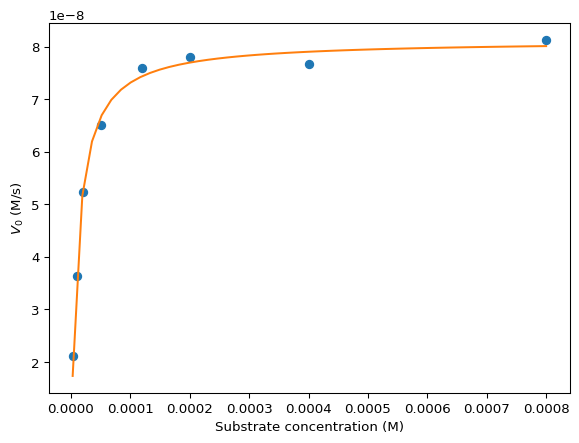

In [161]:
fig, ax = plt.subplots() 

## Your task: Plot the data and the fit
ax.plot(substrate_concentrations, slopes, 'o', label='Data')
ax.plot(S_smooth, V0_fit, label='Fit')

## These add x and y axis labels.
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('$V_0$ (M/s)')
plt.show()

#### (f) Turnover number

Given that the enzyme concentration was
$3.33 \frac{\text{mg}}{\text{L}}$ and the molecular weight of the enzyme
(alkaline phosphatase) is 496.6 $\frac{\text{g}}{\text{mol}}$, calculate
the turnover number $k_{cat}$.

Start by converting the enzyme concentration to molar units and then
calculate the turnover number.

In [163]:
## Your task: Calculate the enzyme concentration and use that and your fit to 
## calculate kcat.
enzyme_conc = (3.33*10**(-3)) / 496.6
kcat = V_max_fit / enzyme_conc
print(kcat)

0.012111970813457657

-   What is the biochemical meaning of this number?